In [1]:
import numpy as np
import matplotlib.pylab as plt
import random as rn
import time
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from matplotlib.path import Path
import shapely.geometry

In [2]:
# Position
x0 = 0
xf = 30
xobs = [[5, 7], [10, 11], [15, 16], [20, 21]]
prox = [2.5, 2.5] # [x, t]

# General RRT Settings
K = 1000
iter_max = 1000
tMax = 20
vmax = 5

In [3]:
# Obstacle Setting
# [start, close, open]
obs1 = [0, 5, 5]
obs2 = [0, 4, 4]
obs3 = [0, 3, 3]
obs4 = [0, 8, 4]
obs_vec = [obs1, obs2, obs3, obs4]

RRT

In [4]:
def distance(a, b):
    return b - a

In [5]:
def obstacle_check(trand, obs):
    temp = trand - obs[0]
    tempt = np.mod(temp, obs[1]+obs[2])
    if tempt >= obs[1] and tempt <= (obs[1]+obs[2]):
        # Not Caught
        return True
    else:
        # Caught
        return False 

def validate(q2):
    check_vec = []
    for i in range(len(xobs)):
        if q2[0] >= xobs[i][0] and q2[0] <= xobs[i][1]:
            if obstacle_check(q2[1], obs_vec[i]):
                check_vec.append(0)
            else:
                check_vec.append(1)
        else:
            check_vec.append(0)
    return check_vec

def time_block_obstacle(pos_obs, time_obs, repeat_index):
    time_translate = repeat_index*(np.sum(time_obs))

    point1 = [pos_obs[0], time_obs[0]+time_translate]
    point2 = [pos_obs[1], time_obs[0]+time_translate]
    point3 = [pos_obs[1], time_obs[0]+time_obs[1]+time_translate]
    point4 = [pos_obs[0], time_obs[0]+time_obs[1]+time_translate]

    return shapely.geometry.Polygon([point1, point2, point3, point4])

In [6]:
"""Fix"""

def random_sample():
    trand = rn.uniform(1e-1, tMax)
    check = rn.uniform(0, 1)
    
    if check >= 0 and check < 0.9:
        xrand = rn.uniform(trand*(-vmax)+x0, trand*vmax+x0)
    elif check >= 0.9:
        xrand = xf
        trand = xf
    qrand = [xrand, trand]
    return qrand

In [7]:
def check_route(q1, q2, t1):
    route_check = []

    line = shapely.geometry.LineString([q1, q2])
    for i in range(len(xobs)):
        obs_number = int((t1//np.sum(obs_vec[i]))+1)
        internal_check = []

        for j in range(obs_number):
            this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
            internal_check.append(line.intersects(this_obstacle))

        # print('internal_check: ', i, internal_check)
        if all(x == False for x in internal_check):
            # No Path Collision Locally
            route_check.append(True)
        else:
            # Path Collision Locally
            route_check.append(False)

    # print('route_check: ', route_check)
    if all(x == True for x in route_check):
        return True # No Path Collision
    else:
        return False # Path Collision

In [8]:
"""Fix"""
def reachable(q0, q1):
    dx = np.abs(q1[0]-q0[0])
    dt = q1[1]-q0[1]
    if dx == 0:
        return True
    else:
        if dt > 0 and np.abs(dx/dt) <= vmax and dt > 0:
            return True
        else:
            return False

In [9]:
def find_neighbor(qrand, V):
    # Find neighbor
    dist_vec = []
    for i in range(len(V)):
        if reachable(V[i], qrand):
            dist_vec.append(distance(V[i][0], qrand[0]))
    if len(dist_vec) > 0:
        closest = dist_vec.index(min(dist_vec))
        qclosest = V[closest]
        return qclosest
    else:
        return None

In [10]:
def extend(qclosest, q1):
    dx = q1[0]-qclosest[0]
    dt = q1[1]-qclosest[1]
    norm = np.sqrt(dx**2 + dt**2)
    dxnorm = dx/norm*vmax
    dtnorm = dt/norm*vmax
    qnew = [qclosest[0]+dxnorm, qclosest[1]+dtnorm]
    return qnew

In [11]:
def find_path(xf, E):
    path_vec = []
    path_vec.append(E[-1][1])
    curr = E[-1][1]
    kek = 0
    while 1:
        for ei in range(len(E)):
            e = E[ei][1]
            if curr[0] == e[0] and curr[1] == e[1]:
                curr = E[ei][0]
                path_vec.append(curr)
                break

        kek += 1
        if curr[0] == x0 and curr[1] == 0:
            return path_vec

In [12]:
"""Standard RRT"""
time_vec = []
success_RRT = 0
iter = 0

while iter < iter_max:
    print('iter: ', iter)
    start = time.time()
    k = 0
    V_RRT = []
    V_RRT.append([x0, 0])
    V_RRT_raw = []
    T_RRT = []
    T_RRT.append(0)
    E_RRT = []
    sanity = []
    path_RRT = None
    while k < K:
    # while 1:
        # print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRT)
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0 and check_route(qclosest, qnew, qrand[1]):
                    break

        # Add V, E
        k += 1
        #print('qrand: ', qrand)
        #print('qnew: ', qnew)
        V_RRT.append(qnew)
        sanity.append(qrand)
        V_RRT_raw.append(qrand)
        E_RRT.append([qclosest, qnew])
        T_RRT.append(qnew[1])

        # Check continue
        dist_check = []
        if np.abs(distance(xf, qnew[0])) <= 1:
            dist_check.append(1)
        else:
            dist_check.append(0)
        if np.sum(dist_check) > 0:
            dist_to_fin = distance(xf, qnew[0])
            qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRT.append(qfin)
            E_RRT.append([qnew, qfin])
            success_RRT += 1
            break
    path_RRT = find_path(xf, E_RRT)
    end = time.time()
    
    time_vec.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec)/len(time_vec))
print('Success Rate: ', success_RRT/iter_max)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39
iter:  40
iter:  41
iter:  42
iter:  43
iter:  44
iter:  45
iter:  46
iter:  47
iter:  48
iter:  49
iter:  50
iter:  51
iter:  52
iter:  53
iter:  54
iter:  55
iter:  56
iter:  57
iter:  58
iter:  59
iter:  60
iter:  61
iter:  62
iter:  63
iter:  64
iter:  65
iter:  66
iter:  67
iter:  68
iter:  69
iter:  70
iter:  71
iter:  72
iter:  73
iter:  74
iter:  75
iter:  76
iter:  77
iter:  78
iter:  79
iter:  80
iter:  81
iter:  82
iter:  83
iter:  84
iter:  85
iter:  86
iter:  87
iter:  88
iter:  89
iter:  90
iter:  91
iter:  92
iter:  93
iter:  94
iter:  95
iter:  96
iter:  97
iter:  98
iter:  99
iter:  100

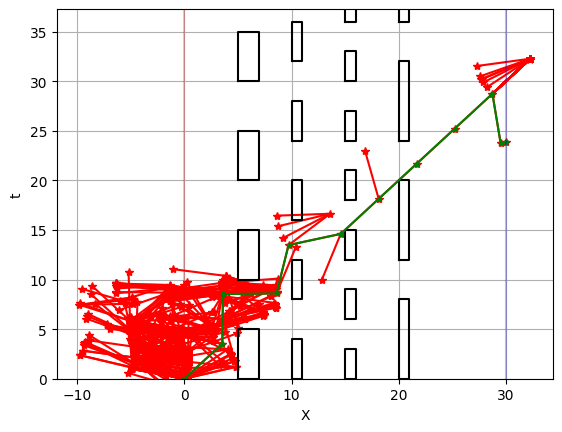

In [13]:
fig = plt.figure()
ax = fig.subplots()
tf = V_RRT[-1][1]
# RRT
for rrtv in V_RRT:
    plt.plot(rrtv[0], rrtv[1], 'r*')
# for rrtvrnd in V_RRT_raw:
#     plt.plot(rrtvrnd[0], rrtvrnd[1], 'm.', alpha=0.8)
for rrte in E_RRT:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Path
for pathi in path_RRT:
    plt.plot(pathi[0], pathi[1], '.g')
for pathi in range(len(path_RRT)-1):
    plt.plot([path_RRT[pathi][0], path_RRT[pathi+1][0]], [path_RRT[pathi][1], path_RRT[pathi+1][1]], '-g')

# Initial/Final
plt.plot([x0, x0], [0, max(T_RRT)+5], 'r-', alpha=0.25)
plt.plot([xf, xf], [0, max(T_RRT)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf+1)
plt.ylim(0, max(T_RRT)+5)
plt.xlabel('X')
plt.ylabel('t')
plt.grid()

Text(0, 0.5, 't (sec)')

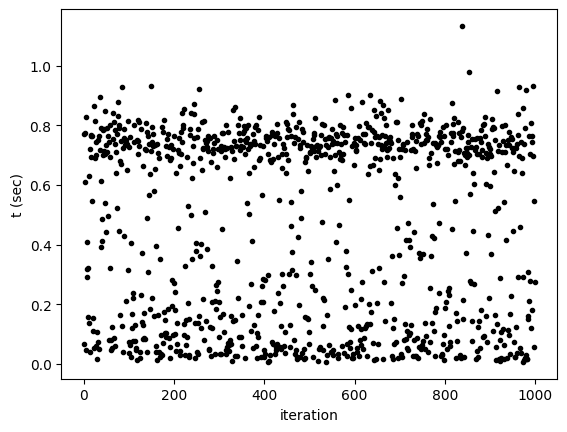

In [14]:
fig = plt.figure()
time_vec_RRT = time_vec
xaxis = np.linspace(0, len(time_vec_RRT)-1, len(time_vec_RRT))
plt.plot(xaxis, time_vec_RRT, '.k')
plt.xlabel('iteration')
plt.ylabel('t (sec)')

RRT-STAR

In [15]:
def neighbors(prox, q0, V_RRTstar):
    output = []
    for v in V_RRTstar:
        if 0 <= q0[0]-v[0] <= prox[0] and 0 <= q0[1]-v[1] <= prox[1] and reachable(q0, v):
            output.append(v)
    return output

In [16]:
"""Stardard RRT*"""
time_vec_star = []
iter = 0
success_RRTstar = 0

while iter < iter_max:
    print('iter: ', iter)
    start = time.time()
    k = 0
    V_RRTstar = []
    V_RRTstar.append([x0, 0])
    T_RRTstar = []
    T_RRTstar.append(0)
    E_RRTstar = []
    while k < K:
        # print('k: ', k)
        while 1:
            # Sample
            qrand = random_sample()
            qclosest = find_neighbor(qrand, V_RRTstar)
            if qclosest is not None:
                qnew = extend(qclosest, qrand)
                
                # Validate
                check_vec = validate(qnew)
                if np.sum(check_vec) == 0:
                    if check_route(qclosest, qnew, qrand[1]):
                        break

        # Add V, E
        k += 1
        V_RRTstar.append(qnew)
        E_RRTstar.append([qclosest, qnew])
        T_RRTstar.append(qnew[1])

        # Rewiring
        if k > 1:
            qmin = qclosest
            cost_old = np.sqrt((qclosest[0]-qnew[0])**2+(qclosest[1]-qnew[1])**2)
            neighbor_vector = neighbors(prox, qnew, V_RRTstar)
            if len(neighbor_vector) > 0:
                for v in neighbor_vector:
                    if cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2) < np.sqrt((qclosest[0]-v[0])**2+(qclosest[1]-v[1])**2) and check_route(v, qnew):
                        cost_old = cost_old+np.sqrt((v[0]-qnew[0])**2+(v[1]-qnew[1])**2)
                        qmin = v
                E_RRTstar.append([qnew, qmin])

        # Check continue
        dist_check = []
        if np.abs(distance(xf, V_RRTstar[-1][0])) <= 1:
            dist_check.append(1)
        else:
            dist_check.append(0)
        if np.sum(dist_check) > 0 or k > K:
            end_cond = dist_check.index(1)
            dist_to_fin = distance(xf, qnew[0])
            qfin = [xf, qnew[1]+np.abs(dist_to_fin/vmax)]
            V_RRTstar.append(qfin)
            E_RRTstar.append([qnew, qfin])
            success_RRTstar += 1
            break
    path_RRTstar = find_path(xf, E_RRTstar)
    end = time.time()
    
    time_vec_star.append(end-start)
    iter += 1

print('Average Computation Time (sec): ', sum(time_vec_star)/len(time_vec_star))
print('Success Rate: ', success_RRTstar/iter_max)

iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
iter:  5
iter:  6
iter:  7
iter:  8
iter:  9
iter:  10
iter:  11
iter:  12
iter:  13
iter:  14
iter:  15
iter:  16
iter:  17
iter:  18
iter:  19
iter:  20
iter:  21
iter:  22
iter:  23
iter:  24
iter:  25
iter:  26
iter:  27
iter:  28
iter:  29
iter:  30
iter:  31
iter:  32
iter:  33
iter:  34
iter:  35
iter:  36
iter:  37
iter:  38
iter:  39
iter:  40
iter:  41
iter:  42
iter:  43
iter:  44
iter:  45
iter:  46
iter:  47
iter:  48
iter:  49
iter:  50
iter:  51
iter:  52
iter:  53
iter:  54
iter:  55
iter:  56
iter:  57
iter:  58
iter:  59
iter:  60
iter:  61
iter:  62
iter:  63
iter:  64
iter:  65
iter:  66
iter:  67
iter:  68
iter:  69
iter:  70
iter:  71
iter:  72
iter:  73
iter:  74
iter:  75
iter:  76
iter:  77
iter:  78
iter:  79
iter:  80
iter:  81
iter:  82
iter:  83
iter:  84
iter:  85
iter:  86
iter:  87
iter:  88
iter:  89
iter:  90
iter:  91
iter:  92
iter:  93
iter:  94
iter:  95
iter:  96
iter:  97
iter:  98
iter:  99
iter:  100

Text(0, 0.5, 't')

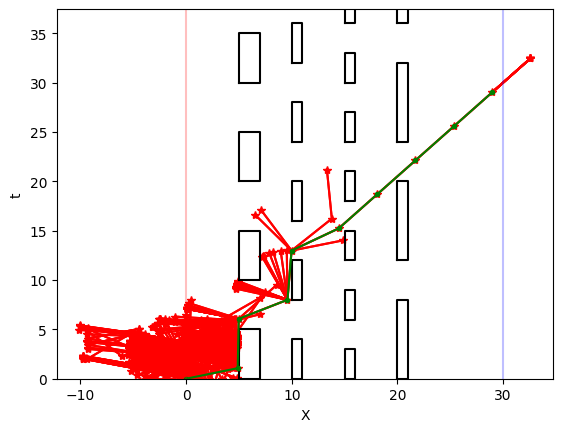

In [18]:
fig = plt.figure()
ax = fig.subplots()
tf = V_RRTstar[-1][1]
# RRTstar
for rrtv in V_RRTstar:
   plt.plot(rrtv[0], rrtv[1], 'r*')
for rrte in E_RRTstar:
    plt.plot([rrte[0][0], rrte[1][0]], [rrte[0][1], rrte[1][1]], 'r-')#, alpha=0.25)

# Obstacle
tspace = np.linspace(0, tf+5, 100)
for i in range(len(xobs)):
    obs_number = int((tf+5//np.sum(obs_vec[i]))+1)
    for j in range(obs_number):
        this_obstacle = time_block_obstacle(xobs[i], obs_vec[i], j)
        plt.plot(*this_obstacle.exterior.xy, 'k')

# Path
for pathi in path_RRTstar:
    plt.plot(pathi[0], pathi[1], '.g')
for pathi in range(len(path_RRTstar)-1):
    plt.plot([path_RRTstar[pathi][0], path_RRTstar[pathi+1][0]], [path_RRTstar[pathi][1], path_RRTstar[pathi+1][1]], '-g')


# Initial/Final
plt.plot([x0, x0], [0, max(T_RRTstar)+5], 'r-', alpha=0.25)
plt.plot([xf, xf], [0, max(T_RRTstar)+5], 'b-', alpha=0.25)

# Plot Limits
#plt.xlim(xf[0]-1, xf+1)
plt.ylim(0, max(T_RRTstar)+5)
plt.xlabel('X')
plt.ylabel('t')
# plt.grid()

Text(0, 0.5, 't (sec)')

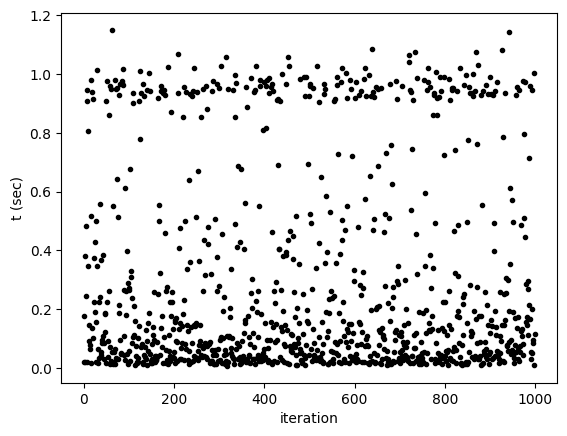

In [ ]:
fig = plt.figure()
xaxis = np.linspace(0, len(time_vec_star)-1, len(time_vec_star))
plt.plot(xaxis, time_vec_star, '.k')
plt.xlabel('iteration')
plt.ylabel('t (sec)')